<a href="https://colab.research.google.com/github/gc-sudha/teaching_datasci/blob/main/GC_ML_Count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning on RNA-seq count data

This project is part of assignment for AFS 505. We implemented umap for feature extraction and a machine learning algorithm, Random Forest (RF) for feature selection in this notebook.

**Import libraries**

In [1]:
# Standard data science.
import numpy as np
import pandas as pd

# Display and plotting imports.
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

# Display and plotting configuration.
%matplotlib inline

import seaborn as sns

import xarray as xr
import pathlib

**Import count data**

In [2]:
count_df = pd.read_csv('/content/drive/MyDrive/AFS505/rice_heat_drought.GEM.raw.txt', sep="\t", index_col =0)
display(count_df.shape)
count_df.head(4)

(55986, 475)

,SRX1423934,SRX1423935,SRX1423936,SRX1423937,SRX1423938,SRX1423939,SRX1423940,SRX1423941,SRX1423942,SRX1423943,...,SRX1424399,SRX1424400,SRX1424401,SRX1424402,SRX1424403,SRX1424404,SRX1424405,SRX1424406,SRX1424407,SRX1424408
LOC_Os06g05820,20,2,22,11,23,39,24,34,33,20,...,5,20,20,38,35,43,25,8,8,21
LOC_Os10g27460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC_Os02g35980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC_Os09g23260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Change to xarray**

In [3]:
count_array = xr.Dataset(
    {"counts":(("Gene", "Sample"), count_df.values)},
    coords={
        "Sample": count_df.columns.values,
        "Gene": count_df.index.values
    }
)
count_array=count_array.transpose()

**Import labels**

In [49]:
label_df = pd.read_csv('/content/drive/MyDrive/AFS505/PRJNA301554.hydroponic.annotations.txt', index_col =1, sep="\t")
label_df.index.rename("Sample", inplace= True)
label_df.head(4)

,BioSample,LoadDate,MBases,MBytes,Run,SRA_Sample,Sample_Name,genotype,time,treatment,...,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,SRA_Study,source_name,tissue
Sample,,,,,,,,,,,,,,,,,,,,,
SRX1423937,SAMN04251851,2015-11-20,1166,764,SRR2931043,SRS1156717,GSM1933349,"Azuenca (AZ; IRGC#328, Japonica)",30 min,CONTROL,...,Illumina HiSeq 2000,PAIRED,cDNA,TRANSCRIPTOMIC,Oryza sativa,ILLUMINA,2016-01-04,SRP065945,Rice leaf,leaf
SRX1423938,SAMN04251852,2015-11-20,4005,2500,SRR2931044,SRS1156720,GSM1933350,"Azuenca (AZ; IRGC#328, Japonica)",45 min,CONTROL,...,Illumina HiSeq 2000,PAIRED,cDNA,TRANSCRIPTOMIC,Oryza sativa,ILLUMINA,2016-01-04,SRP065945,Rice leaf,leaf
SRX1423939,SAMN04251853,2015-11-20,4852,3262,SRR2931045,SRS1156719,GSM1933351,"Azuenca (AZ; IRGC#328, Japonica)",45 min,CONTROL,...,Illumina HiSeq 2000,PAIRED,cDNA,TRANSCRIPTOMIC,Oryza sativa,ILLUMINA,2016-01-04,SRP065945,Rice leaf,leaf
SRX1423940,SAMN04251854,2015-11-20,3610,2437,SRR2931046,SRS1156716,GSM1933352,"Azuenca (AZ; IRGC#328, Japonica)",60 min,CONTROL,...,Illumina HiSeq 2000,PAIRED,cDNA,TRANSCRIPTOMIC,Oryza sativa,ILLUMINA,2016-01-04,SRP065945,Rice leaf,leaf


**Sanity checks**

In [5]:
label_df.index.intersection(count_df.columns.values)

Index(['SRX1423937', 'SRX1423938', 'SRX1423939', 'SRX1423940', 'SRX1423941',
       'SRX1423942', 'SRX1423943', 'SRX1423944', 'SRX1423945', 'SRX1423946',
       ...
       'SRX1424399', 'SRX1424400', 'SRX1424401', 'SRX1424402', 'SRX1424403',
       'SRX1424404', 'SRX1424405', 'SRX1424406', 'SRX1424407', 'SRX1424408'],
      dtype='object', name='Sample', length=475)

In [6]:
label_df.index.difference(count_df.columns.values)

Index([], dtype='object', name='Sample')

In [7]:
label_df.index.symmetric_difference(count_df.columns.values)

Index([], dtype='object', name='Sample')

**Change label to xarray format**

In [50]:
label_ds = label_df.to_xarray()
label_ds

<xarray.Dataset>
Dimensions:             (Sample: 475)
Coordinates:
  * Sample              (Sample) object 'SRX1423937' ... 'SRX1424408'
Data variables: (12/28)
    BioSample           (Sample) object 'SAMN04251851' ... 'SAMN04251607'
    LoadDate            (Sample) object '2015-11-20' ... '2015-11-19'
    MBases              (Sample) int64 1166 4005 4852 3610 ... 3098 3529 2922
    MBytes              (Sample) int64 764 2500 3262 2437 ... 1983 2370 1862
    Run                 (Sample) object 'SRR2931043' ... 'SRR2931514'
    SRA_Sample          (Sample) object 'SRS1156717' ... 'SRS1156251'
    ...                  ...
    Organism            (Sample) object 'Oryza sativa' ... 'Oryza sativa'
    Platform            (Sample) object 'ILLUMINA' 'ILLUMINA' ... 'ILLUMINA'
    ReleaseDate         (Sample) object '2016-01-04' ... '2016-01-04'
    SRA_Study           (Sample) object 'SRP065945' 'SRP065945' ... 'SRP065945'
    source_name         (Sample) object 'Rice leaf' 'Rice leaf' ... 'Rice leaf'
    tissue              (Sample) object 'leaf' 'leaf' 'leaf' ... 'leaf' 'leaf'

**Merge two xarray files**

In [51]:
ds = label_ds.merge(count_array)
ds

<xarray.Dataset>
Dimensions:             (Gene: 55986, Sample: 475)
Coordinates:
  * Sample              (Sample) object 'SRX1423934' ... 'SRX1424408'
  * Gene                (Gene) object 'LOC_Os06g05820' ... 'LOC_Os07g03418'
Data variables: (12/29)
    BioSample           (Sample) object 'SAMN04251848' ... 'SAMN04251607'
    LoadDate            (Sample) object '2015-11-20' ... '2015-11-19'
    MBases              (Sample) int64 4016 5202 4053 1166 ... 3098 3529 2922
    MBytes              (Sample) int64 2738 3652 2719 764 ... 1983 2370 1862
    Run                 (Sample) object 'SRR2931040' ... 'SRR2931514'
    SRA_Sample          (Sample) object 'SRS1156722' ... 'SRS1156251'
    ...                  ...
    Platform            (Sample) object 'ILLUMINA' 'ILLUMINA' ... 'ILLUMINA'
    ReleaseDate         (Sample) object '2016-01-04' ... '2016-01-04'
    SRA_Study           (Sample) object 'SRP065945' 'SRP065945' ... 'SRP065945'
    source_name         (Sample) object 'Rice leaf' 'Rice leaf' ... 'Rice leaf'
    tissue              (Sample) object 'leaf' 'leaf' 'leaf' ... 'leaf' 'leaf'
    counts              (Sample, Gene) int64 20 0 0 0 0 0 ... 0 52 335 0 666 0

* subset counts data

In [52]:
ds['counts'].values

array([[ 20,   0,   0, ...,   0, 637,   0],
       [  2,   0,   0, ...,   0, 186,   0],
       [ 22,   0,   0, ...,   0, 545,   0],
       ...,
       [  8,   0,   0, ...,   0, 411,   0],
       [  8,   0,   0, ...,   0, 311,   0],
       [ 21,   0,   0, ...,   0, 666,   0]])

## Feature Extraction

### Principle Component Analysis

In [53]:
from sklearn.decomposition import PCA # import library for PCA

**Log transform count data**

In [54]:
log_count = np.log(ds['counts'].values +1)
log_count.shape

(475, 55986)

**Implement PCA transformation**

* Dimensions will be reduced from 55986 to 475

In [55]:
pca_mdl = PCA()
pca_transformed = pca_mdl.fit_transform(log_count)
pca_transformed.shape

(475, 475)

**Create dataframe named 'labels'**
* First two dimesions obtained from PCA transformation, treatment, time and genotype information. 

In [56]:
labels = ds[['treatment', 'time', 'genotype']].to_dataframe()
labels['pca_dim1']= pca_transformed[:,0]
labels['pca_dim2']= pca_transformed[:,1]
print(labels.shape)
labels.head()

(475, 5)


,treatment,time,genotype,pca_dim1,pca_dim2
SRX1423934,CONTROL,15 min,"Azuenca (AZ; IRGC#328, Japonica)",37.108346,-68.074801
SRX1423935,CONTROL,15 min,"Azuenca (AZ; IRGC#328, Japonica)",-116.908587,-59.547955
SRX1423936,CONTROL,30 min,"Azuenca (AZ; IRGC#328, Japonica)",51.533883,-63.633032
SRX1423937,CONTROL,30 min,"Azuenca (AZ; IRGC#328, Japonica)",-151.394819,-66.998652
SRX1423938,CONTROL,45 min,"Azuenca (AZ; IRGC#328, Japonica)",50.441570,-60.076879


**Visualization**
* visulaize the treatment structure plotting first two dimensions of PCA

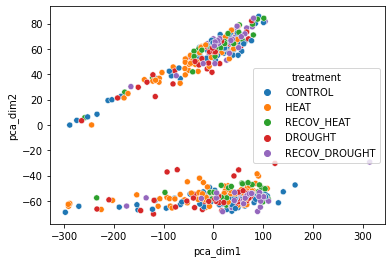

In [57]:
sns.scatterplot(data = labels, x = 'pca_dim1', y = 'pca_dim2', hue = 'treatment');

### Umap

**install umap**

In [58]:
#pip install umap-learn

**Import umap**

In [59]:
import umap

**Transform the count data using umap**

In [60]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(log_count)
embedding.shape

(475, 2)

**Check treatment labels**

In [61]:
labels['treatment'].unique()

array(['CONTROL', 'HEAT', 'RECOV_HEAT', 'DROUGHT', 'RECOV_DROUGHT'],
      dtype=object)

**Visualization**
* Plot first two dimesions obtained from Umap and color represents the treatment

''

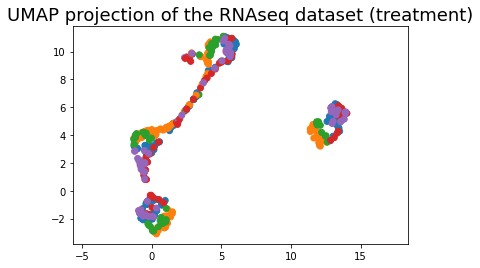

In [62]:
#plot treatment
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels['treatment'].map({"CONTROL":0, "HEAT":1, "RECOV_HEAT":2, "DROUGHT":3, "RECOV_DROUGHT":4})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the RNAseq dataset (treatment)', fontsize=18)
;

**Return genotype lables**

In [63]:
labels['genotype'].unique()

array(['Azuenca (AZ; IRGC#328, Japonica)',
       'Kinandang puti (KP; IRGC#44513, Indica)',
       'Pandan wangi (PW; IRGC#35834, Japonica)',
       'Tadukan (TD; IRGC#9804, Indica)'], dtype=object)

**Wrangling**
* Remove extra information from genotype infromation using str split

In [64]:
labels['genotype'] = labels['genotype'].str.split('(').str[0]

In [65]:
labels['genotype'].unique()

array(['Azuenca ', 'Kinandang puti ', 'Pandan wangi ', 'Tadukan '],
      dtype=object)

**Visualization**
* Visulaize genotype structure

Text(0.5, 1.0, 'UMAP projection of the RNAseq dataset (genotype)')

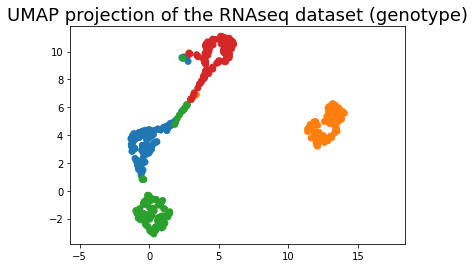

In [66]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels['genotype'].map({"Azuenca ":0, "Kinandang puti ":1, "Pandan wangi ":2, "Tadukan ":3})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the RNAseq dataset (genotype)', fontsize=18)

**Visulaize using sns**

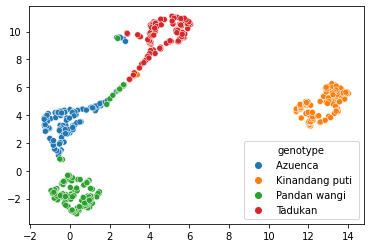

In [67]:
sns.scatterplot(x = embedding[:, 0],
    y = embedding[:, 1],
    hue= labels['genotype']);
 

**Visualization**
* Visualize for time points

In [68]:
labels['time'].unique()

array(['15 min', '30 min', '45 min', '60 min', '75 min', '90 min',
       '105 min', '120 min', '135 min', '150 min', '165 min', '180 min',
       '195 min', '210 min', '225 min', '240 min', '270 min', '300 min'],
      dtype=object)

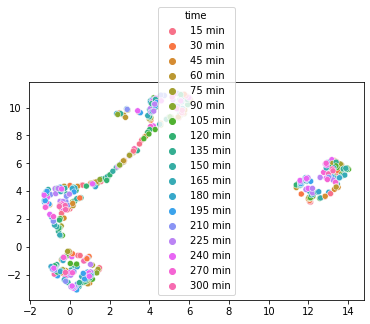

In [73]:
sns.scatterplot(x = embedding[:, 0],
    y = embedding[:, 1],
    hue= labels['time']);

**Visualize both treament(color) and genotype(shape)**

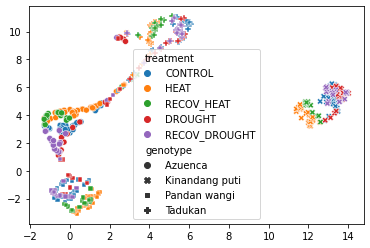

In [74]:
sns.scatterplot(x = embedding[:, 0],
    y = embedding[:, 1],
    hue= labels['treatment'],
    style = labels['genotype']);

## Feature selection

**Import library**

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
X = log_count
y = labels['treatment'].values

**Fit random forest classifier**
* Max_depth =2

In [34]:
clf = RandomForestClassifier(max_depth = 2, random_state=97)
clf.fit(X,y)

RandomForestClassifier(max_depth=2, random_state=97)

In [ ]:
clf.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
clf.feature_importances_.shape

(55986,)

**Accuracy value**

In [ ]:
clf.score(X,y)

0.783157894736842

**Return number of important features selected by RF**

In [35]:
(clf.feature_importances_ >0).sum()

269

**Subset important genes**

In [36]:
sel_genes = ds['Gene'].values[clf.feature_importances_>0]
sel_genes

array(['LOC_Os10g42780', 'LOC_Os09g16920', 'LOC_Os09g25090',
       'LOC_Os04g49510', 'LOC_Os03g20370', 'LOC_Os05g14240',
       'LOC_Os05g35970', 'LOC_Os04g44950', 'LOC_Os12g25120',
       'LOC_Os05g51560', 'LOC_Os03g49210', 'LOC_Os11g37700',
       'LOC_Os12g05210', 'LOC_Os02g04340', 'LOC_Os07g48550',
       'LOC_Os01g04370', 'LOC_Os01g04380', 'LOC_Os12g41390',
       'LOC_Os03g16020', 'LOC_Os02g54720', 'LOC_Os07g48560',
       'LOC_Os04g57560', 'LOC_Os09g27830', 'LOC_Os07g08970',
       'LOC_Os04g58830', 'LOC_Os01g05650', 'LOC_Os07g49280',
       'LOC_Os11g39990', 'LOC_Os04g24220', 'LOC_Os03g63330',
       'LOC_Os01g50940', 'LOC_Os03g25050', 'LOC_Os04g33310',
       'LOC_Os06g03670', 'LOC_Os05g38280', 'LOC_Os06g25010',
       'LOC_Os01g63930', 'LOC_Os02g15930', 'LOC_Os10g02480',
       'LOC_Os02g54140', 'LOC_Os08g02540', 'LOC_Os06g04070',
       'LOC_Os06g42560', 'LOC_Os07g39350', 'LOC_Os06g11980',
       'LOC_Os03g39760', 'LOC_Os03g18130', 'LOC_Os02g13300',
       'LOC_Os05g46560',

**Subset important genes with count data**

In [43]:
sel_log_count = log_count[:,clf.feature_importances_>0 ]
display(sel_log_count.shape)

(475, 269)

**Transform selected genes with Umap**

In [44]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(sel_log_count)
embedding.shape

(475, 2)

**Visualize**

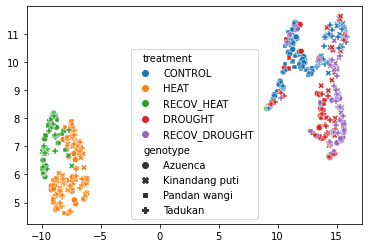

In [45]:
sns.scatterplot( x = embedding[:, 0],
    y = embedding[:, 1],
    hue= labels['treatment'],
    style = labels['genotype'],
    );

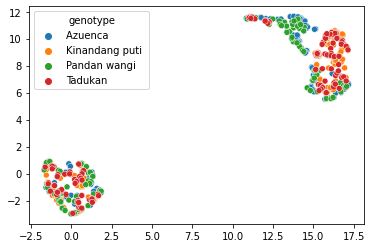

In [ ]:
sns.scatterplot( x = embedding[:, 0],
    y = embedding[:, 1],
    hue= labels['genotype'],
    );

#### Plot Decision tree

In [46]:
from sklearn import tree

[Text(0.6785714285714286, 0.9444444444444444, 'X[3677] <= 6.354\ngini = 0.775\nsamples = 475\nvalue = [143, 71, 128, 70, 63]'),
 Text(0.4714285714285714, 0.8333333333333334, 'X[43658] <= 2.803\ngini = 0.626\nsamples = 285\nvalue = [143, 71, 0, 70, 1]'),
 Text(0.2714285714285714, 0.7222222222222222, 'X[22731] <= 6.519\ngini = 0.358\nsamples = 174\nvalue = [137, 21, 0, 15, 1]'),
 Text(0.14285714285714285, 0.6111111111111112, 'X[17680] <= 1.242\ngini = 0.542\nsamples = 53\nvalue = [29, 21, 0, 2, 1]'),
 Text(0.05714285714285714, 0.5, 'X[50914] <= 2.441\ngini = 0.338\nsamples = 35\nvalue = [28, 5, 0, 1, 1]'),
 Text(0.02857142857142857, 0.3888888888888889, 'gini = 0.0\nsamples = 25\nvalue = [25, 0, 0, 0, 0]'),
 Text(0.08571428571428572, 0.3888888888888889, 'X[13581] <= 5.34\ngini = 0.64\nsamples = 10\nvalue = [3, 5, 0, 1, 1]'),
 Text(0.05714285714285714, 0.2777777777777778, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0, 0, 0]'),
 Text(0.11428571428571428, 0.2777777777777778, 'X[35115] <= 4.072\

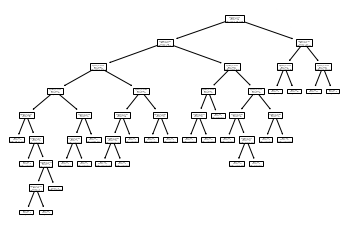

In [47]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)
tree.plot_tree(clf)

From Dr.Biggs (Take a look at this)
* PyMC 
* Stan (similar to PyMC)
* JAX 
* Optax
* Tensorflow
* Patsy python